In [102]:
import numpy as np
import matplotlib.pyplot as plt
"""
Ho-Lee Model - Ensuring that model price of the ZCBs matches the market price
"""

# Discounting curve
def P(t,T):
    r = 0.05
    return np.exp(-r * (T-t))

class HoLee:
    def __init__( self
                 ,discountingCurve : np.array
                 ,numOfSteps : int
                 ,numOfPaths : int
                 ,simulationCutoffDate : float
                 ,sigma: float
                 ):
        self.discountingCurve = discountingCurve
        self.numOfSteps = numOfSteps
        self.numOfPaths = numOfPaths
        self.T = simulationCutoffDate
        self.sigma = sigma
    
    def F0T(self, T : float):
        dt = 0.0001
        return -(np.log(P(0,T+dt)) - np.log(P(0,T-dt)))/(2 * dt)
        
    def generatePaths(self):
        dt = self.T / self.numOfSteps
        timeGrid = np.linspace(dt, self.T, self.numOfSteps)

        # Initial interest rate is a forward rate at time t -> 0
        r0 = self.F0T(0.0) * np.ones([self.numOfPaths, 1])
        theta = lambda t : (self.F0T(t + dt) - self.F0T(t - dt))/(2 * dt) + self.sigma**2 * t
        theta = np.array([theta(t) for t in timeGrid])
        theta = np.tile(theta, [self.numOfPaths,1])
        
        dZt = np.random.standard_normal([self.numOfPaths, self.numOfSteps])
        dWt = np.sqrt(dt) * dZt
        dr_t = dt * theta + self.sigma * dWt
        dr_t = np.concat([r0, dr_t], axis=1)
        r_t = np.cumsum(dr_t, axis=1)
        return r_t

    # Price a ZCB in the Ho-Lee model, by computing expectations 
    # under the risk-neutral valuation formula
    def ZCB(self, t1, t2, r_t : np.matrix):
        idx_t1 = int(t1 * 365)
        idx_t2 = int(t2 * 365)
        dt = self.T / self.numOfSteps
        return np.average(np.exp(np.sum([-(r_t[:,t] * dt) for t in range(idx_t1, idx_t2)], axis=0)))


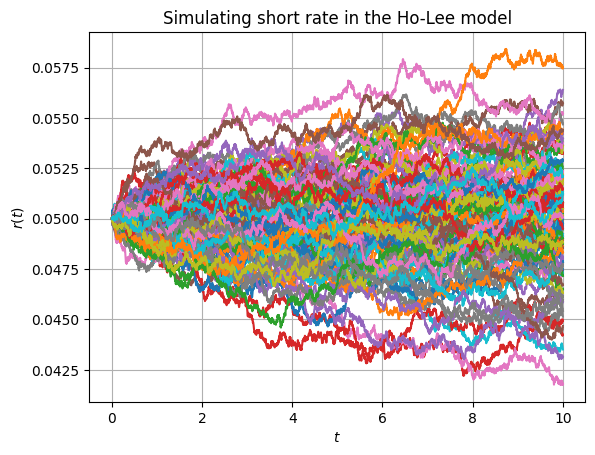

In [109]:

T = 10.0                # Simulation cutoff time T in years
numOfSteps = int(365 * T)    # Number of steps
numOfPaths = 100

timeGrid = np.linspace(0.0, T, numOfSteps + 1)
discountingCurve = np.array([P(0,t) for t in timeGrid])

# In this experiment we compare the ZCB from the market and Monte Carlo
engine = HoLee(
    discountingCurve=discountingCurve,
    numOfSteps = numOfSteps,
    numOfPaths = numOfPaths,
    simulationCutoffDate = T,
    sigma = 0.001
)

paths = engine.generatePaths()

plt.xlabel(r'$t$')
plt.ylabel(r'$r(t)$')
plt.title(r'Simulating short rate in the Ho-Lee model')
plt.grid(True)
for path in paths:
    plt.plot(timeGrid, path)

plt.show()




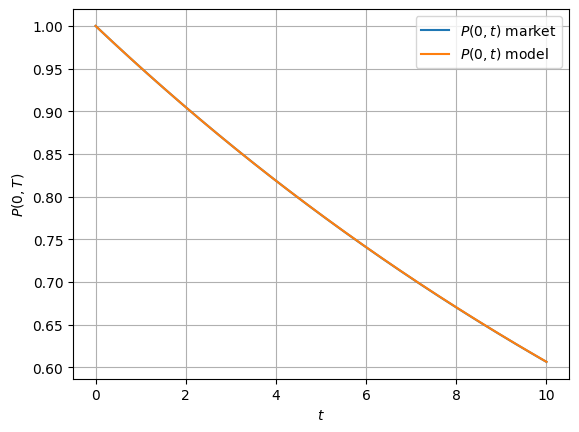

In [110]:
# Computing ZCB Model prices
ZCBPriceVector = np.array([engine.ZCB(0,T, paths) for T in timeGrid])

# Plot Discount curve and Model ZCB Prices
plt.close()

plt.xlabel(r'$t$')
plt.ylabel(r'$P(0,T)$')
plt.grid(True)

plt.plot(timeGrid, discountingCurve)
plt.plot(timeGrid, ZCBPriceVector)
plt.legend([r'$P(0,t)$ market', r'$P(0,t)$ model'])
plt.show()